In [1]:
import numpy as np
import pandas as pd
import hist
from hist import Hist
import awkward as ak
import json
import uproot
import math
from coffea import util
import pandas as pd
import pickle
from copy import copy, deepcopy
import ROOT as r
import os

import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.CMS)

Welcome to JupyROOT 6.28/04


In [2]:
# Insert the output directory
out_dir = "../outfiles/Run3Summer22EE/roothist"

# Insert the name of the ROOT histogram you are about to create
file_name = f'{out_dir}/roothist.root'

# Table of contents <a class="anchor" id="toc"></a>

* [Create ROOT histogram out of hist histograms](#root)
* [Plot ROOT histogram to confirm the previous procedure](#plot)

# Create ROOT histogram out of hist histograms <a class="anchor" id="root"></a>
[Back to Table of Contents](#toc)

In [3]:
# Insert the pt bin edges
ptbins = [300, 350, 400, 450, 500, 1200]

# Insert the double b-tagging discriminant score
wp = 0.9858

# Would you like QCD in the signal region to be QCD in control region scaled down (only for debugging)?
scale_QCD = False
# Would you like to add data (set to 'False' if you want to add pseduo data)?
add_data = True

fix = {}

mc = pickle.load(open('../outfiles/Run3Summer22EE/hist/mc.pkl','rb'))
lumi = mc['lumi']
mc = mc['hist']
data = pickle.load(open('../outfiles/Run3Summer22EE/cutflow/data/data.pkl','rb'))

if os.path.isfile(file_name):
    os.remove(file_name)

fout = uproot.create(file_name)

for i, b in enumerate(ptbins[:-1]):

    for sys in ['nominal', 'JESUp', 'JESDown', 'JERUp', 'JERDown']:
    
        for p in ['QCD', "TTbar", 'W', 'VV', 'ggF', 'VBF', 'ZH', 'WH', 'ttH']:
            
            if p == 'QCD' and sys != "nominal":
                    continue

            h = mc[{
                'process' : hist.loc(p),
                'pt' : slice(hist.loc(ptbins[i]), hist.loc(ptbins[i+1]), sum),
                'genflav': slice(0, len, sum),
                'systematic' : hist.loc(sys),
            }]

            hfail = h[{
                'disc' : slice(0, hist.loc(wp), sum),
            }]

            if p == "QCD" and scale_QCD:
                hpass = h[{
                    'disc' : slice(0, hist.loc(wp), sum),
                }] *  (h[{'disc' : slice(hist.loc(wp), len, sum), 'mass' : sum
                         }].value / h[{'disc' : slice(0, hist.loc(wp), sum), 'mass' : sum}].value)
            else:
                hpass = h[{
                    'disc' : slice(hist.loc(wp), len, sum),
                }]

            with uproot.update(file_name) as fout:
                fout["ggf_pass_pt"+str(i+1)+"_"+p+f"_{sys}"] = hpass
                fout["ggf_fail_pt"+str(i+1)+"_"+p+f"_{sys}"] = hfail

        for p in ['ZJets']:
        
            h = mc[{
                'process' : hist.loc(p),
                'pt' : slice(hist.loc(ptbins[i]), hist.loc(ptbins[i+1]), sum),
                'systematic' : hist.loc(sys),
            }]
            
            hpass = h[{
                'disc' : slice(hist.loc(wp), len, sum),
                'genflav': slice(1, 3, sum),
            }]
            
            hfail = h[{
                'disc' : slice(0, hist.loc(wp), sum),
                'genflav': slice(1, 3, sum),
            }]
            
            hpass_bb = h[{
                'disc' : slice(hist.loc(wp), len,sum),
                'genflav': slice(3, len, sum),
            }]
            
            hfail_bb = h[{
                'disc' : slice(0, hist.loc(wp), sum),
                'genflav': slice(3, len, sum),
            }]
        
            with uproot.update(file_name) as fout:
                fout["ggf_pass_pt"+str(i+1)+"_"+p+"bb"+f"_{sys}"] = hpass
                fout["ggf_fail_pt"+str(i+1)+"_"+p+"bb"+f"_{sys}"] = hfail

                fout["ggf_pass_pt"+str(i+1)+"_"+p+"qq"+f"_{sys}"] = hpass_bb
                fout["ggf_fail_pt"+str(i+1)+"_"+p+"qq"+f"_{sys}"] = hfail_bb
         
    if add_data:
        
        h = data[{
                'process' : sum,
                'pt' : slice(hist.loc(ptbins[i]), hist.loc(ptbins[i+1]), sum),
                'genflav': slice(0, len, sum),
                'cut' : -1,
            }]

        hfail = h[{
            'disc' : slice(0, hist.loc(wp), sum),
        }]

        hpass = h[{
            'disc' : slice(hist.loc(wp), len, sum),
        }]

        with uproot.update(file_name) as fout:
            fout["ggf_pass_pt"+str(i+1)+"_data_nominal"] = hpass
            fout["ggf_fail_pt"+str(i+1)+"_data_nominal"] = hfail

# with uproot.open(file_name) as fin:
#     for name in fin.keys():
#         print(name)

# Plot ROOT histogram to confirm the previous procedure <a class="anchor" id="plot"></a>
[Back to Table of Contents](#toc)

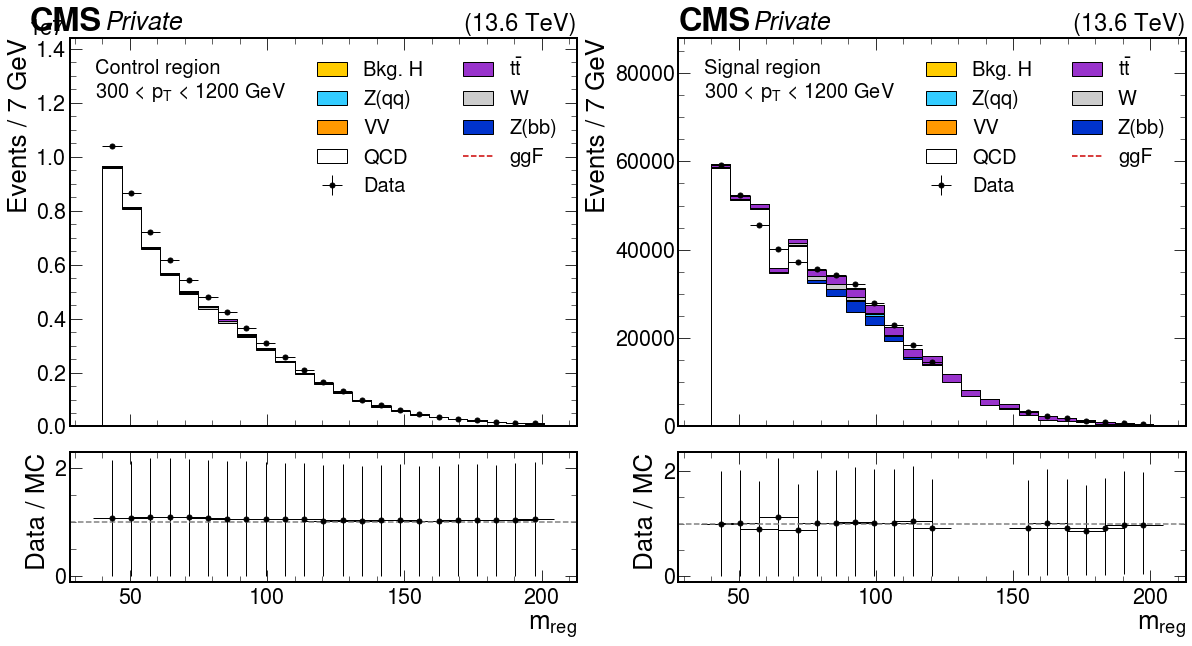

In [6]:
# This cell plots the distributions of the newly created ROOT histograms,
# in order to double-check the creation.

from coffea.hist import clopper_pearson_interval, poisson_interval
plt.style.use(mplhep.style.CMS)

colour = {
    "QCD" : "white",
    "ZJetsbb" : "#0033cc",
    "ZJetsqq" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
    "VV" : "#ff9900",
}

label = {
    "QCD" : "QCD",
    "ZJetsbb" : "Z(bb)",
    "ZJetsqq" : "Z(qq)",
    "W" : "W",
    "TTbar" : r"$t\bar{t}$",
    "Single t" : "Single t",
    "VV" : "VV",
}

f = uproot.open(file_name)

    
fig, ((ax1, ax2), (rax1, rax2)) = plt.subplots(
    2, 2, figsize=(20, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
)
fig.subplots_adjust(hspace=0.1)

for reg, ax, rax in [('fail', ax1, rax1), ('pass', ax2, rax2)]:
    
    ax.set_ylabel("Events / 7 GeV")
    rax.set_ylabel("Data / MC")
    rax.set_xlabel(r"m$_{reg}$")
    ax.set_xlabel(" ")

    hs = []
    labels = []
    colours = []
    
    hists = {
        "QCD" : None,
        "ZJetsbb" : None,
        "ZJetsqq" : None,
        "W" : None,
        "TTbar" : None,
        "Single t" : None,
        "VV" : None,
        "ggF" : None,
        "data" : None,
        "Bkg. H." : None,
        "MC" : None,
    }

    for i, _ in enumerate(ptbins[:-1]):

        for process in colour.keys():

            h = f[f'ggf_{reg}_pt{i+1}_{process}_nominal'].to_hist()

            if not hists[process]:
                hists[process] = h
            else:
                hists[process] = hists[process] + h

        higgs_h = None

        for process in ['VBF', 'ZH', 'WH', 'ttH']:

            h = f[f'ggf_{reg}_pt{i+1}_{process}_nominal'].to_hist()

            if not higgs_h:
                higgs_h = h
            else:
                higgs_h += h

        if not hists["Bkg. H."]:
            hists["Bkg. H."] = h
        else:
            hists["Bkg. H."] = hists["Bkg. H."] + h

        h_ggf = f[f'ggf_{reg}_pt{i+1}_ggF_nominal'].to_hist()

        if not hists["ggF"]:
            hists["ggF"] = h
        else:
            hists["ggF"] = hists["ggF"] + h
        
        h_data = f[f'ggf_{reg}_pt{i+1}_data_nominal'].to_hist()

        if not hists["data"]:
            hists["data"] = h_data
        else:
            hists["data"] = hists["data"] + h_data
            
    for process in colour.keys():

        hs.append(hists[process])
        labels.append(label[process])
        colours.append(colour[process])
    
    hs.append(higgs_h)
    labels.append("Bkg. H")
    colours.append("#ffcc00")

    mplhep.histplot(
        hs,
        ax=ax,
        label=labels,
        stack=True,
        color=colours,
        histtype="fill",
        edgecolor="black",
        linewidth=1,
    )
    
    mplhep.histplot(
        hists["ggF"], 
        ax=ax,
        yerr=False,
        color="#cc0000",
        label=f"ggF",
        linestyle="dashed",
    )

    h_data = hists["data"]
    
    # Blind data in the signal region
    if reg == "pass":
        for i_nan in [12, 13, 14, 15]:
                h_data[i_nan] = [np.nan, np.nan]

    mplhep.histplot(
        h_data, 
        ax=ax, 
        histtype="errorbar",
        xerr=True,
        c="black",
        label=f"Data",
    )
    
    hs_mc = None
    for process in colour.keys():
        if not hs_mc:
            hs_mc = hists[process]
        else:
            hs_mc = hs_mc + hists[process] 
    
    
    centers = hs_mc.axes[0].centers
    sumw_num, sumw2_num = h_data.values(), h_data.variances()
    sumw_denom, sumw2_denom = hs_mc.values(), hs_mc.variances()

    rsumw = sumw_num / np.maximum(1, sumw_denom)
    rsumw_unc = poisson_interval(
        rsumw,
        sumw2_num / sumw_denom**2
    )

    data_err_opts = {
        'linestyle': 'none',
        'marker': '.',
        'markersize': 10.,
        'color': 'k',
        'elinewidth': 1,
    }

    rax.errorbar(
        centers,
        rsumw,
        xerr=centers[1]-centers[0],
        yerr=rsumw_unc,
        **data_err_opts,
    )

    rax.axhline(1, color='gray',ls='--')

    mplhep.cms.label(
        ax=ax, 
        data=True, 
        fontsize=25,
        label="Private",
#          year=2022,
#         com=13.6,
#         lumi=f"{lumi}",
        rlabel="(13.6 TeV)"
    )

    handles, labels = ax.get_legend_handles_labels()
    order = [0, 4, 1, 6, 8, 2, 3, 5, 7]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

    ax.set_ylim(0, max(hists["QCD"].values()) * 1.5)

    reg_text = "Signal" if reg == "pass" else "Control"
    plt.text(0.05, 0.83, f"{reg_text} region\n300 < " + r"$p_T$" + f" < 1200 GeV",
                fontsize=20,
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=ax.transAxes
               )

#     ax.set_xlim(40, 200)
    
    t = ax.yaxis.get_offset_text()
    t.set_x(-0.08)

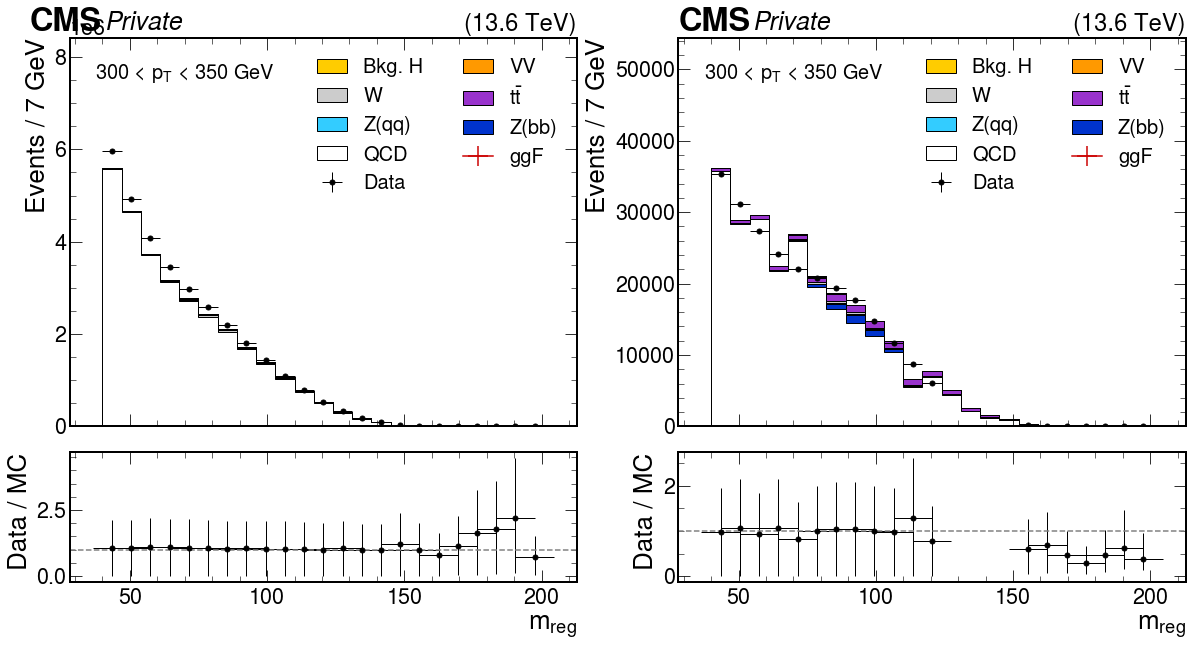

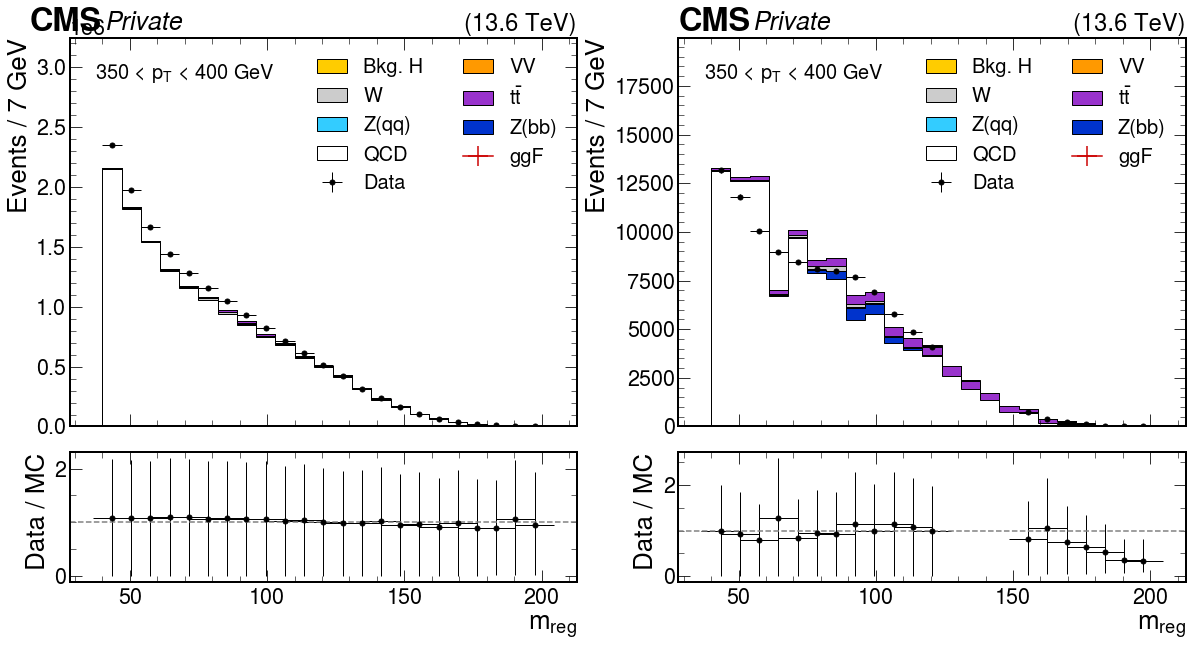

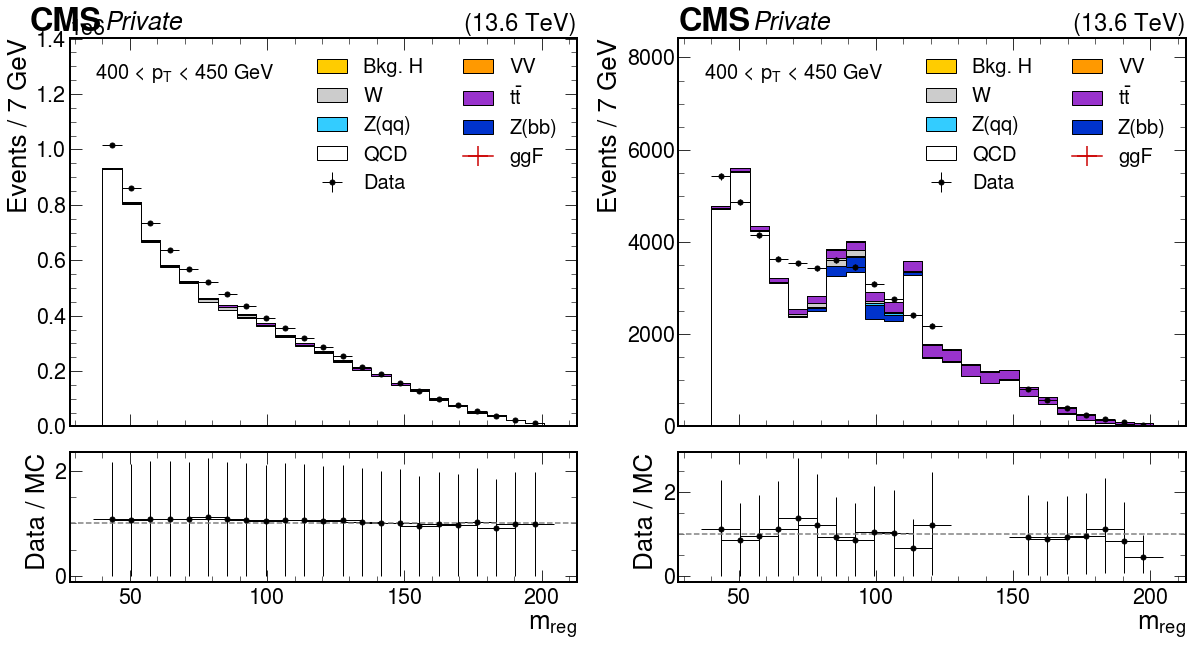

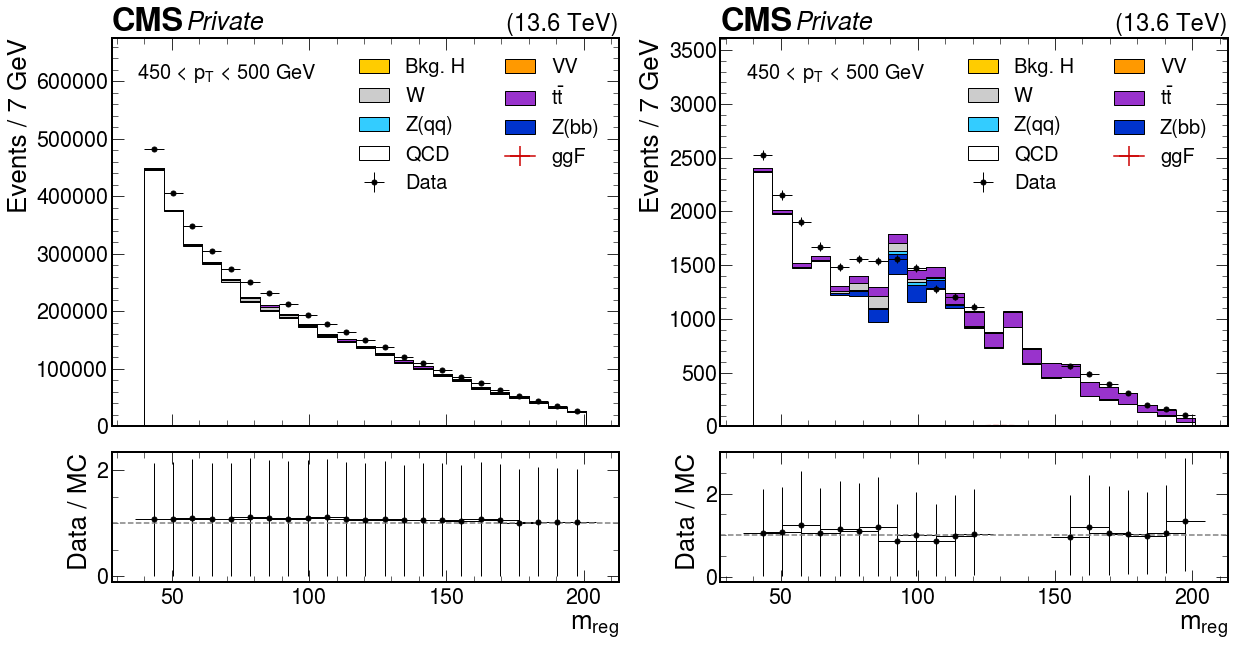

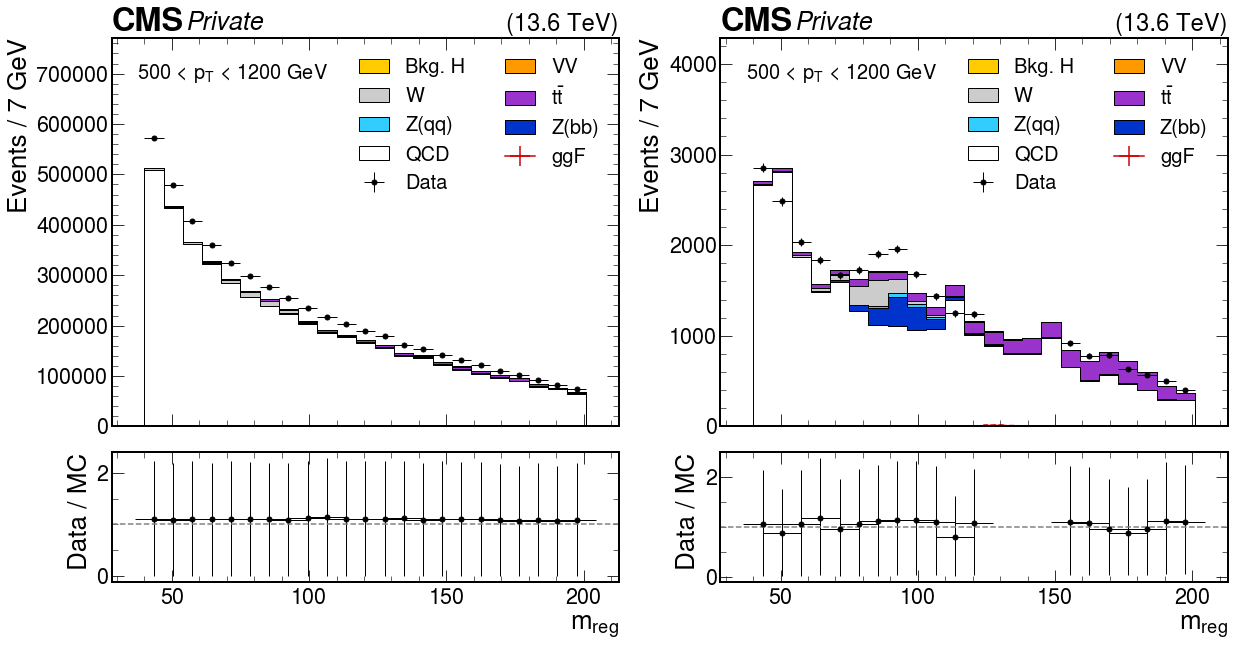

In [7]:
# This cell plots the distributions of the newly created ROOT histograms,
# in order to double-check the creation.

plt.style.use(mplhep.style.CMS)

f = uproot.open(file_name)

colour = {
    "QCD" : "white",
    "ZJetsbb" : "#0033cc",
    "ZJetsqq" : "#33ccff",
    "W" : "#cccccc",
    "TTbar" : "#9933cc",
    "VV" : "#ff9900",
}

label = {
    "QCD" : "QCD",
    "ZJetsbb" : "Z(bb)",
    "ZJetsqq" : "Z(qq)",
    "W" : "W",
    "TTbar" : r"$t\bar{t}$",
    "Single t" : "Single t",
    "VV" : "VV",
}

for i, _ in enumerate(ptbins[:-1]):
    
    fig, ((ax1, ax2), (rax1, rax2)) = plt.subplots(
        2, 2, figsize=(20, 10), gridspec_kw={"height_ratios": (3, 1)}, sharex=True
    )
    fig.subplots_adjust(hspace=0.1)

    for reg, ax, rax in [('fail', ax1, rax1), ('pass', ax2, rax2)]:

        hs = []
        labels = []
        colours = []

        ax.set_ylabel("Events / 7 GeV")
        rax.set_ylabel("Data / MC")
        rax.set_xlabel(r"m$_{reg}$")
        ax.set_xlabel(" ")

        for process in colour.keys():

            h = f[f'ggf_{reg}_pt{i+1}_{process}_nominal'].to_hist()

            hs.append(h)
            labels.append(label[process])
            colours.append(colour[process])

        higgs_h = None

        for process in ['VBF', 'ZH', 'WH', 'ttH']:

            h = f[f'ggf_{reg}_pt{i+1}_{process}_nominal'].to_hist()

            if not higgs_h:
                higgs_h = h
            else:
                higgs_h += h

        hs.append(higgs_h)
        labels.append("Bkg. H")
        colours.append("#ffcc00")

        mplhep.histplot(
            hs,
            ax=ax,
            label=labels,
            stack=True,
            color=colours,
            histtype="fill",
            edgecolor="black",
            linewidth=1,
        )

        h = f[f'ggf_{reg}_pt{i+1}_ggF_nominal'].to_hist()

        mplhep.histplot(
            h, 
            ax=ax,
            color="#cc0000",
            label=f"ggF",
            linestyle="dashed",
        )

        h = f[f'ggf_{reg}_pt{i+1}_data_nominal'].to_hist()
        # Blind data in the signal region
        if reg == "pass":
            for i_nan in [12, 13, 14, 15]:
                    h[i_nan] = [np.nan, np.nan]

        mplhep.histplot(
            h, 
            ax=ax, 
            histtype="errorbar",
            xerr=True,
            c="black",
            label=f"Data",
        )

        hs_mc = None
        for h_mc in hs:
            if not hs_mc:
                hs_mc = h_mc
            else:
                hs_mc += h_mc

        centers = h.axes[0].centers
        sumw_num, sumw2_num = h.values(), h.variances()
        sumw_denom, sumw2_denom = hs_mc.values(), hs_mc.variances()

        rsumw = sumw_num / np.maximum(1, sumw_denom)
        rsumw_unc = poisson_interval(
            rsumw,
            sumw2_num / sumw_denom**2
        )

        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        rax.errorbar(
            centers,
            rsumw,
            xerr=centers[1]-centers[0],
            yerr=rsumw_unc,
            **data_err_opts,
        )

        rax.axhline(1, color='gray',ls='--')

        mplhep.cms.label(
            ax=ax, 
            data=True, 
            fontsize=25,
            label="Private",
#             year=2022,
#             com=13.6,
#             lumi=f"{lumi}",
            rlabel="(13.6 TeV)"
        )

        handles, labels = ax.get_legend_handles_labels()
        order = [0, 3, 4, 6, 8, 1, 2, 5, 7]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=20, ncols=2)

        ax.set_ylim(0, max(hs[0].values()) * 1.5)

        plt.text(0.05, 0.88, f"{ptbins[i]:.0f} < " + r"$p_T$" + f" < {ptbins[i+1]} GeV",
            fontsize=20,
            horizontalalignment='left',
            verticalalignment='bottom',
            transform=ax.transAxes
           )